In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from galpy.util.bovy_coords import *
from search_local import *

gaia_data = search_phase_space(0., 0., 0., 0., 0., 0., 0.5, 0.)
R, phi, z = rect_to_cyl(gaia_data[:,0], gaia_data[:,1], gaia_data[:,2])
vR, vT, vz = rect_to_cyl_vec(gaia_data[:,3], gaia_data[:,4], gaia_data[:,5], gaia_data[:,0], gaia_data[:,1], gaia_data[:,2])
gaia_data = np.stack((R, phi, z, vR, vT, vz), axis=1)

print('#stars', len(gaia_data))
print('min/max/mean (R)', min(gaia_data[:,0]), max(gaia_data[:,0]), np.mean(gaia_data[:,0]))
print('min/max/mean (phi)', min(gaia_data[:,1]), max(gaia_data[:,1]), np.mean(gaia_data[:,1]))
print('min/max/mean (z)', min(gaia_data[:,2]), max(gaia_data[:,2]), np.mean(gaia_data[:,2]))
print('min/max/mean (vR)', min(gaia_data[:,3]), max(gaia_data[:,3]), np.mean(gaia_data[:,3]))
print('min/max/mean (vT)', min(gaia_data[:,4]), max(gaia_data[:,4]), np.mean(gaia_data[:,4]))
print('min/max/mean (vz)', min(gaia_data[:,5]), max(gaia_data[:,5]), np.mean(gaia_data[:,5]))
print(np.std(gaia_data[:,0]), np.std(gaia_data[:,1]), np.std(gaia_data[:,2]), np.std(gaia_data[:,3]), np.std(gaia_data[:,4]), np.std(gaia_data[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1699708
min/max/mean (R) 7.800911997788074 8.799620277350543 8.291940989763331
min/max/mean (phi) 3.0813469383936956 3.2018352601712126 3.141300302894572
min/max/mean (z) -0.47224099228924643 0.5251864323212104 0.020554162071444157
min/max/mean (vR) -548.5939275793445 657.8733574312542 -1.0635896390181552
min/max/mean (vT) -908.3028370417318 407.85361294256495 -210.4756252801884
min/max/mean (vz) -392.75735712064113 374.51594061818395 -0.5273981260258953
0.19569240168043248 0.024711492153012812 0.16310598222016867 37.24396957743784 27.049247224061276 19.622803785914808


In [2]:
#Importing the required modules
import numpy as np
from sklearn.neighbors import KernelDensity

#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-07-15 - Updated - Ayush Pandhi
    """
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Multivariate Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = 5 * np.nanstd(inputs) * N ** (-1/10.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-07-15 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_gaia_epanechnikov = generate_KDE(gaia_data, 'epanechnikov')

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(gaia_data[:,0])
mean_phi = np.ones((N, 1))*np.mean(gaia_data[:,1])
mean_z = np.ones((N, 1))*np.mean(gaia_data[:,2])
mean_vR = np.ones((N, 1))*np.mean(gaia_data[:,3])
mean_vT = np.ones((N, 1))*np.mean(gaia_data[:,4])
mean_vz = np.ones((N, 1))*np.mean(gaia_data[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(gaia_data[:,0]), max(gaia_data[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(gaia_data[:,1]), max(gaia_data[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(gaia_data[:,2]), max(gaia_data[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(gaia_data[:,3]), max(gaia_data[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(gaia_data[:,4]), max(gaia_data[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(gaia_data[:,5]), max(gaia_data[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Variable R at Scotts bw


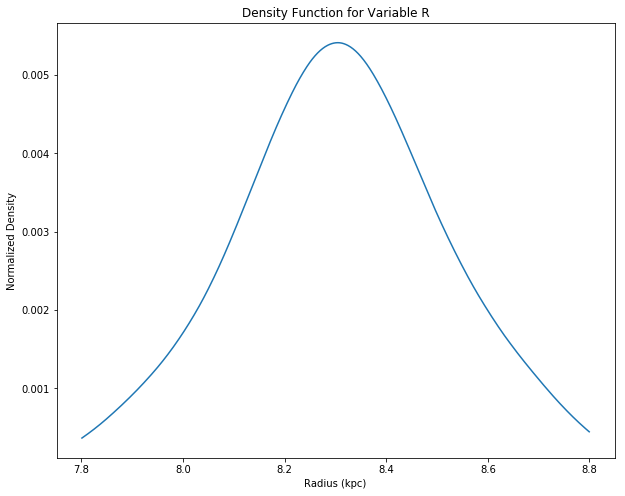

In [7]:
#Variable R plot
print('Variable R at Scotts bw')
plt.figure(figsize = (10, 8))
Rplot_epanechnikov = kde_gaia_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)
plt.xlabel('Radius (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable R')
plt.savefig('gaia_zscore_cyl_variable_R')
plt.show()

Variable phi at Scotts bw


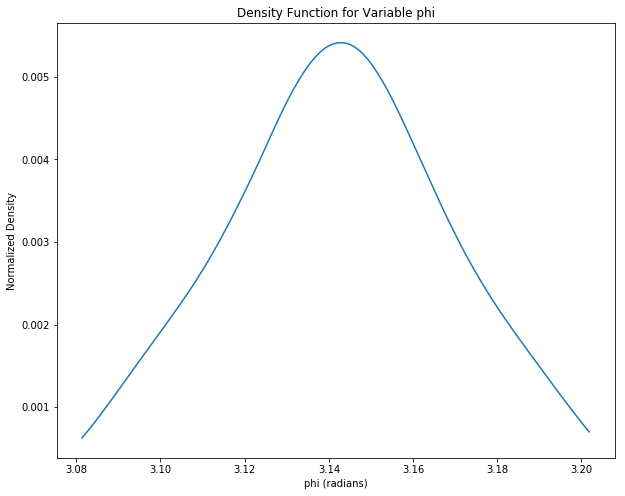

In [8]:
#Variable phi plot
print('Variable phi at Scotts bw')
plt.figure(figsize = (10, 8))
phiplot_epanechnikov = kde_gaia_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)
plt.xlabel('phi (radians)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable phi')
plt.savefig('gaia_zscore_cyl_variable_phi')
plt.show()

Variable z at Scotts bw


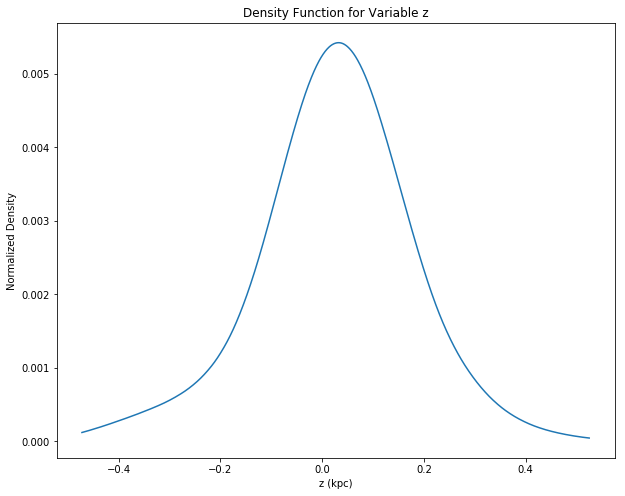

In [9]:
#Variable z plot
print('Variable z at Scotts bw')
plt.figure(figsize = (10, 8))
zplot_epanechnikov = kde_gaia_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable z')
plt.savefig('gaia_zscore_cyl_variable_z')
plt.show()

Variable vR at Scotts bw


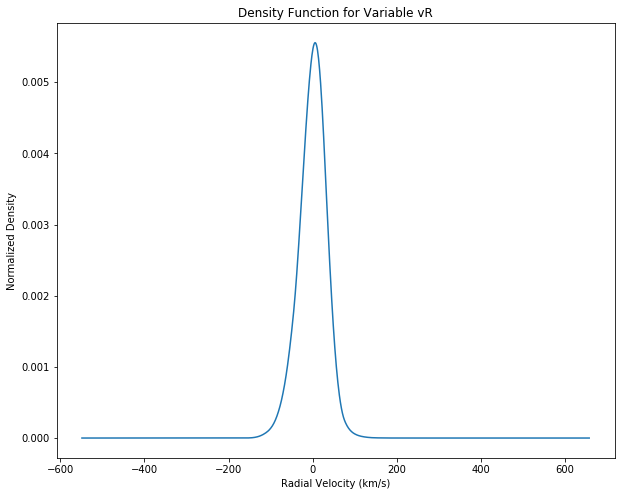

In [10]:
#Variable vR plot
print('Variable vR at Scotts bw')
plt.figure(figsize = (10, 8))
vRplot_epanechnikov = kde_gaia_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vR')
plt.savefig('gaia_zscore_cyl_variable_vR')
plt.show()

Variable vT at Scotts bw


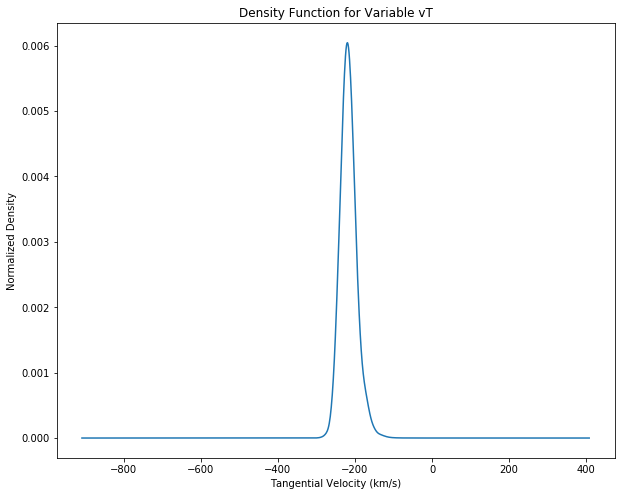

In [11]:
#Variable vT plot
print('Variable vT at Scotts bw')
plt.figure(figsize = (10, 8))
vTplot_epanechnikov = kde_gaia_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)
plt.xlabel('Tangential Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vT')
plt.savefig('gaia_zscore_cyl_variable_vT')
plt.show()

Variable vz at Scotts bw


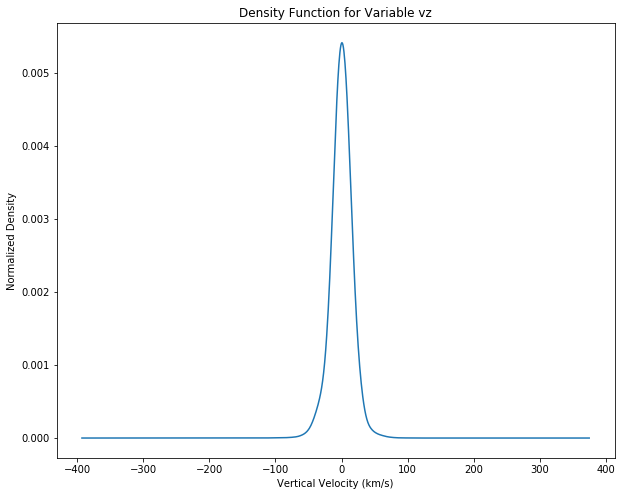

In [12]:
#Variable vz plot
print('Variable vz at Scotts bw')
plt.figure(figsize = (10, 8))
vzplot_epanechnikov = kde_gaia_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)
plt.xlabel('Vertical Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vz')
plt.savefig('gaia_zscore_cyl_variable_vz')
plt.show()

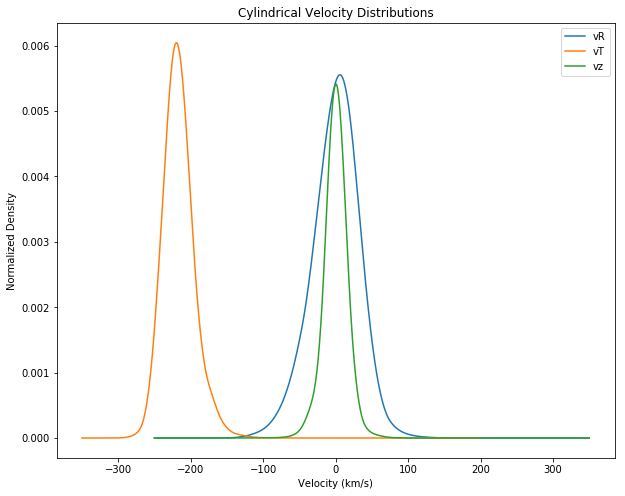

In [14]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-350, 200, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities
plt.figure(figsize = (10, 8))

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_gaia_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_gaia_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_gaia_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Cylindrical Velocity Distributions')
plt.legend()
plt.savefig('gaia_zscore_cyl_velocity_distribution')
plt.show()

In [5]:
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-400, 200, 100)

# -----------------
# Integrate over vR
# -----------------

def kde_gaia_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_gaia_epanechnikov, vR): #bounds of vT = [-300, 0], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_gaia_cyl_vR, -300, 0, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_gaia_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_gaia_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_gaia_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_gaia_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_gaia_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_gaia_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_gaia_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [-300, 0]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_gaia_cyl_vz, -100, 100, -300, 0, args=([8.3, 3.14, 0., vz]), epsabs=0.001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_gaia_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].
KDE Evaluations along vR from [-400, 200] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -400.0
Value: 1.1429363375066618e-14
Time to integrate: 2.93s
Time elapsed: 0.05 min

Evaluation: 2
Evaluating at vR = -393.93939393939394
Value: 2.3156725592596382e-07
Time to integrate: 3.28s
Time elapsed: 0.1 min

Evaluation: 3
Evaluating at vR = -387.8787878787879
Value: 5.095402169670986e-06
Time to integrate: 3.52s
Time elapsed: 0.16 min

Evaluation: 4
Evaluating at vR = -381.8181818181818
Value: 1.4836732262560467e-05
Time to integrate: 3.94s
Time elapsed: 0.23 min

Evaluation: 5
Evaluating at vR = -375.75757575757575
Value: 3.0198710554233322e-05
Time to integrate: 4.32s
Time elapsed: 0.3 min

Evaluation: 6
Evaluating at vR = -369.6969696969697
Value: 6.105592231345607e-05
Time to integrate: 4.09s
Time elapsed: 0.37 min

Evaluation: 7
Evaluating at vR = -363.6363636363636
Value: 0.000100228

Value: 0.009707946954569693
Time to integrate: 8.82s
Time elapsed: 9.57 min

Evaluation: 63
Evaluating at vR = -24.24242424242425
Value: 0.009897008219754352
Time to integrate: 12.77s
Time elapsed: 9.78 min

Evaluation: 64
Evaluating at vR = -18.181818181818187
Value: 0.009900300484714014
Time to integrate: 8.02s
Time elapsed: 9.92 min

Evaluation: 65
Evaluating at vR = -12.121212121212125
Value: 0.009693983917894756
Time to integrate: 7.46s
Time elapsed: 10.04 min

Evaluation: 66
Evaluating at vR = -6.060606060606062
Value: 0.009469930342579813
Time to integrate: 14.0s
Time elapsed: 10.28 min

Evaluation: 67
Evaluating at vR = 0.0
Value: 0.009164392799367016
Time to integrate: 11.77s
Time elapsed: 10.47 min

Evaluation: 68
Evaluating at vR = 6.060606060606062
Value: 0.008753365027243762
Time to integrate: 14.72s
Time elapsed: 10.72 min

Evaluation: 69
Evaluating at vR = 12.121212121212125
Value: 0.00831291345064498
Time to integrate: 15.72s
Time elapsed: 10.98 min

Evaluation: 70
Eval

Value: 1.7833801541712362
Time to integrate: 34.08s
Time elapsed: 3.49 min

Evaluation: 25
Evaluating at vT = -254.54545454545456
Value: 3.391286244844407
Time to integrate: 53.46s
Time elapsed: 4.38 min

Evaluation: 26
Evaluating at vT = -248.4848484848485
Value: 5.773402453164271
Time to integrate: 26.85s
Time elapsed: 4.83 min

Evaluation: 27
Evaluating at vT = -242.42424242424244
Value: 8.74148754676002
Time to integrate: 65.64s
Time elapsed: 5.92 min

Evaluation: 28
Evaluating at vT = -236.36363636363637
Value: 11.953519158099033
Time to integrate: 50.82s
Time elapsed: 6.77 min

Evaluation: 29
Evaluating at vT = -230.3030303030303
Value: 14.91364530092127
Time to integrate: 51.08s
Time elapsed: 7.62 min

Evaluation: 30
Evaluating at vT = -224.24242424242425
Value: 16.999087382961065
Time to integrate: 88.87s
Time elapsed: 9.1 min

Evaluation: 31
Evaluating at vT = -218.1818181818182
Value: 17.703723049531813
Time to integrate: 191.29s
Time elapsed: 12.29 min

Evaluation: 32
Evalua

Value: 0.0011757580439220794
Time to integrate: 7.32s
Time elapsed: 29.61 min

Evaluation: 89
Evaluating at vT = 133.33333333333337
Value: 0.001049073482764209
Time to integrate: 7.21s
Time elapsed: 29.73 min

Evaluation: 90
Evaluating at vT = 139.39393939393938
Value: 0.0009777887137138116
Time to integrate: 7.52s
Time elapsed: 29.85 min

Evaluation: 91
Evaluating at vT = 145.4545454545455
Value: 0.0008767659936409619
Time to integrate: 6.83s
Time elapsed: 29.97 min

Evaluation: 92
Evaluating at vT = 151.5151515151515
Value: 0.0007201862315017978
Time to integrate: 6.98s
Time elapsed: 30.08 min

Evaluation: 93
Evaluating at vT = 157.57575757575762
Value: 0.000547581649532463
Time to integrate: 6.51s
Time elapsed: 30.19 min

Evaluation: 94
Evaluating at vT = 163.63636363636363
Value: 0.0003669456740824299
Time to integrate: 6.58s
Time elapsed: 30.3 min

Evaluation: 95
Evaluating at vT = 169.69696969696975
Value: 0.0002300055230974696
Time to integrate: 2.1s
Time elapsed: 30.34 min

Eva

Value: 0.006773001493140789
Time to integrate: 14.14s
Time elapsed: 4.65 min

Evaluation: 53
Evaluating at vz = -84.84848484848487
Value: 0.007275865387621915
Time to integrate: 13.71s
Time elapsed: 4.87 min

Evaluation: 54
Evaluating at vz = -78.78787878787881
Value: 0.007925980336538217
Time to integrate: 18.79s
Time elapsed: 5.19 min

Evaluation: 55
Evaluating at vz = -72.72727272727275
Value: 0.008420406391024371
Time to integrate: 8.22s
Time elapsed: 5.32 min

Evaluation: 56
Evaluating at vz = -66.66666666666669
Value: 0.00870233116086713
Time to integrate: 8.61s
Time elapsed: 5.47 min

Evaluation: 57
Evaluating at vz = -60.60606060606062
Value: 0.009367763582140485
Time to integrate: 19.71s
Time elapsed: 5.8 min

Evaluation: 58
Evaluating at vz = -54.54545454545456
Value: 0.010726455885559082
Time to integrate: 7.96s
Time elapsed: 5.93 min

Evaluation: 59
Evaluating at vz = -48.4848484848485
Value: 0.012152154981624115
Time to integrate: 14.02s
Time elapsed: 6.16 min

Evaluation:

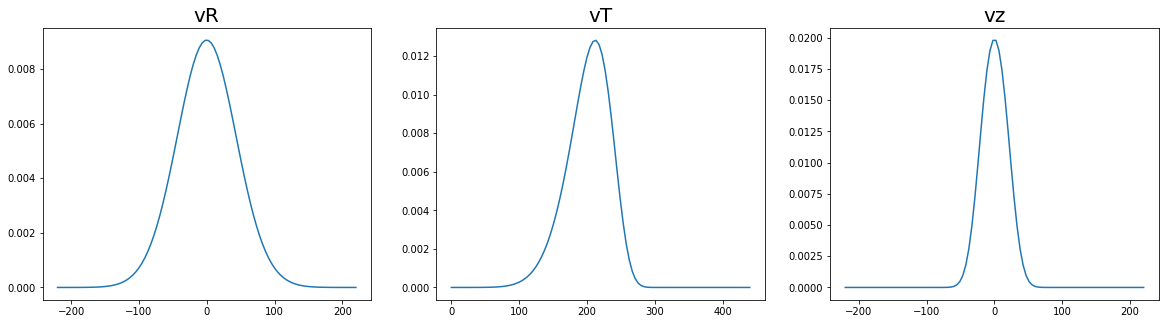

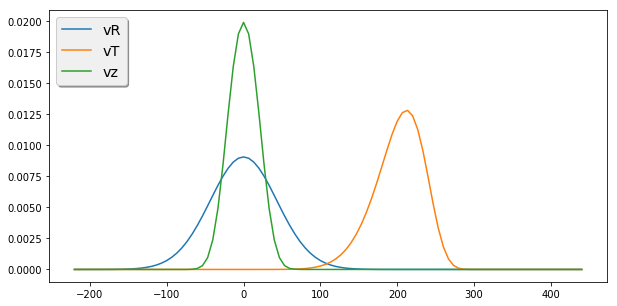

In [6]:
from galpy.df import quasiisothermaldf
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import actionAngleAdiabatic
import numpy 

aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.45,c=True)
qdfS= quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aAS,cutcounter=True)

#initialize mean values for (R,vR,vT,z,vz)
mR,mz = 8.3/8. ,0./8. #convert to nat. units

vRs= np.linspace(-1,1,100) #odd endpoints because galpy uses natural units
vTs= np.linspace(0,2,100)
vzs= np.linspace(-1,1,100)

#Calculating the probability of vR without regard for vT or vz 
#is called marginalizing over the remaining probabilities.
#This is the opposite of conditional probability. 

pvR= np.array([qdfS.pvR(vR,mR,mz) for vR in vRs]) #uses Gauss-Legendre integration
pvT= np.array([qdfS.pvT(vT,mR,mz) for vT in vTs])
pvz= np.array([qdfS.pvz(vz,mR,mz) for vz in vzs])

#plot!
fig, ax = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(20,5))

ax[0].plot(vRs*220, pvR/numpy.sum(pvR)/(vRs[1]-vRs[0])/220) #convert to physical units and normalize area to 1 
ax[0].set_title('vR', fontsize=20)
ax[1].plot(vTs*220, pvT/numpy.sum(pvT)/(vTs[1]-vTs[0])/220)
ax[1].set_title('vT', fontsize=20)
ax[2].plot(vRs*220, pvz/numpy.sum(pvR)/(vzs[1]-vzs[0])/220)
ax[2].set_title('vz', fontsize=20)


#above graphs overlayed
vs= np.linspace(-1,2,100)

pvR= np.array([qdfS.pvR(v,mR,mz) for v in vs])
pvT= np.array([qdfS.pvT(v,mR,mz) for v in vs])
pvz= np.array([qdfS.pvz(v,mR,mz) for v in vs])

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR') #convert to physical units and normalize area to 1 
ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT')
ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
plt.show()

In [7]:
gaia_data2 = search_phase_space(0., 0., 0., 0., 0., 0., 0.05, 0.)
R, phi, z = rect_to_cyl(gaia_data2[:,0], gaia_data2[:,1], gaia_data2[:,2])
vR, vT, vz = rect_to_cyl_vec(gaia_data2[:,3], gaia_data2[:,4], gaia_data2[:,5], gaia_data2[:,0], gaia_data2[:,1], gaia_data2[:,2])
gaia_data2 = np.stack((R, phi, z, vR, vT, vz), axis=1)

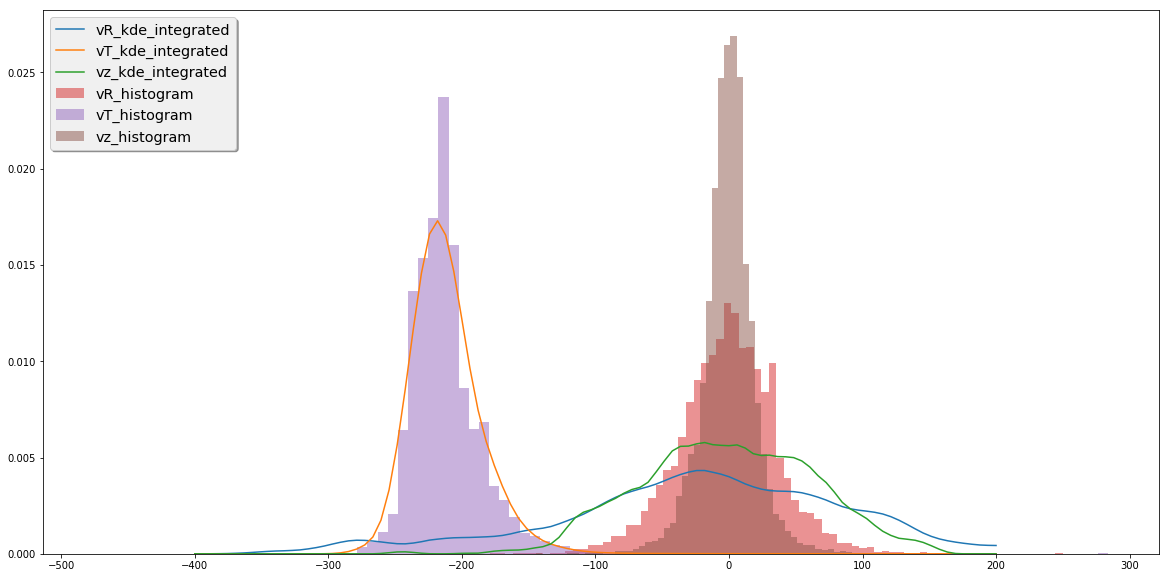

In [16]:
# overplotting qdf and kde integrated
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR_kde_integrated') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT_kde_integrated')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz_kde_integrated')
ax.hist(vR, bins=100, normed=True, label='vR_histogram', alpha=0.5)
ax.hist(vT, bins=100, normed=True, label='vT_histogram', alpha=0.5)
ax.hist(vz, bins=100, normed=True, label='vz_histogram', alpha=0.5)
#ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR_qdf_integrated')
#ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT_qdf_integrated')
#ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz_qdf_integrated')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
plt.savefig('gaia_zscore_cyl_integrated_histogram_compare')
plt.show()

In [18]:
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-400, 200, 1000)

# -----------------
# Integrate over vR
# -----------------

def kde_gaia_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_gaia_epanechnikov, vR): #bounds of vT = [-300, 0], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_gaia_cyl_vR, -300, 0, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.001)  # args=(R, phi, z, vR)

vR_output = np.ones([1000])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_gaia_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_gaia_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_gaia_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_gaia_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([1000])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_gaia_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_gaia_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_gaia_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_gaia_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [-300, 0]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_gaia_cyl_vz, -100, 100, -300, 0, args=([8.3, 3.14, 0., vz]), epsabs=0.001)  # args=(R, phi, z, vR)

vz_output = np.ones([1000])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-400, 200] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_gaia_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With R, phi, z = 8.3, 3.14, 0., integrating over vT from [=300, 0] and vz from [-100, 100].
KDE Evaluations along vR from [-400, 200] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -400.0
Value: 1.1429363375066618e-14
Time to integrate: 1.78s
Time elapsed: 0.03 min

Evaluation: 2
Evaluating at vR = -399.3993993993994
Value: 3.211574292494471e-14
Time to integrate: 1.76s
Time elapsed: 0.06 min

Evaluation: 3
Evaluating at vR = -398.79879879879877
Value: 2.163050803842371e-13
Time to integrate: 0.63s
Time elapsed: 0.07 min

Evaluation: 4
Evaluating at vR = -398.1981981981982
Value: 1.2094593379764245e-13
Time to integrate: 1.65s
Time elapsed: 0.1 min

Evaluation: 5
Evaluating at vR = -397.5975975975976
Value: 2.505720542224937e-13
Time to integrate: 1.76s
Time elapsed: 0.13 min

Evaluation: 6
Evaluating at vR = -396.996996996997
Value: 4.092009526025941e-14
Time to integrate: 1.81s
Time elapsed: 0.16 min

Evaluation: 7
Evaluating at vR = -396.39639639639637
Value: 3.08085653174

Value: 0.00010223020696028677
Time to integrate: 3.11s
Time elapsed: 2.72 min

Evaluation: 63
Evaluating at vR = -362.76276276276275
Value: 0.00010675848516115825
Time to integrate: 3.18s
Time elapsed: 2.77 min

Evaluation: 64
Evaluating at vR = -362.1621621621622
Value: 0.000111517068041086
Time to integrate: 3.11s
Time elapsed: 2.82 min

Evaluation: 65
Evaluating at vR = -361.5615615615616
Value: 0.00011660521280527054
Time to integrate: 3.24s
Time elapsed: 2.88 min

Evaluation: 66
Evaluating at vR = -360.96096096096096
Value: 0.00012218066797816288
Time to integrate: 3.19s
Time elapsed: 2.93 min

Evaluation: 67
Evaluating at vR = -360.36036036036035
Value: 0.00012652204888753476
Time to integrate: 3.04s
Time elapsed: 2.98 min

Evaluation: 68
Evaluating at vR = -359.75975975975973
Value: 0.00013412841236101178
Time to integrate: 3.12s
Time elapsed: 3.03 min

Evaluation: 69
Evaluating at vR = -359.1591591591592
Value: 0.0001396489223813252
Time to integrate: 2.99s
Time elapsed: 3.08 m

Value: 0.00040980807065481886
Time to integrate: 4.47s
Time elapsed: 6.31 min

Evaluation: 125
Evaluating at vR = -325.5255255255255
Value: 0.0004149722344645122
Time to integrate: 4.45s
Time elapsed: 6.39 min

Evaluation: 126
Evaluating at vR = -324.92492492492494
Value: 0.0004187258803351455
Time to integrate: 4.52s
Time elapsed: 6.46 min

Evaluation: 127
Evaluating at vR = -324.3243243243243
Value: 0.00042566834430174806
Time to integrate: 4.45s
Time elapsed: 6.54 min

Evaluation: 128
Evaluating at vR = -323.7237237237237
Value: 0.0004318163752996298
Time to integrate: 3.42s
Time elapsed: 6.59 min

Evaluation: 129
Evaluating at vR = -323.12312312312315
Value: 0.0004382157657839464
Time to integrate: 4.44s
Time elapsed: 6.67 min

Evaluation: 130
Evaluating at vR = -322.52252252252254
Value: 0.00044444138086924696
Time to integrate: 4.5s
Time elapsed: 6.74 min

Evaluation: 131
Evaluating at vR = -321.9219219219219
Value: 0.000452063645885108
Time to integrate: 3.4s
Time elapsed: 6.8 m

Value: 0.001451744004378835
Time to integrate: 7.52s
Time elapsed: 11.52 min

Evaluation: 188
Evaluating at vR = -287.6876876876877
Value: 0.0014687115227550664
Time to integrate: 7.51s
Time elapsed: 11.64 min

Evaluation: 189
Evaluating at vR = -287.08708708708707
Value: 0.001483894061477448
Time to integrate: 7.46s
Time elapsed: 11.77 min

Evaluation: 190
Evaluating at vR = -286.48648648648646
Value: 0.0014992522472177996
Time to integrate: 7.31s
Time elapsed: 11.89 min

Evaluation: 191
Evaluating at vR = -285.8858858858859
Value: 0.0015146068563844602
Time to integrate: 7.29s
Time elapsed: 12.01 min

Evaluation: 192
Evaluating at vR = -285.2852852852853
Value: 0.0015296686355840813
Time to integrate: 7.29s
Time elapsed: 12.13 min

Evaluation: 193
Evaluating at vR = -284.68468468468467
Value: 0.0015423676800727106
Time to integrate: 7.39s
Time elapsed: 12.26 min

Evaluation: 194
Evaluating at vR = -284.0840840840841
Value: 0.0015528046352171728
Time to integrate: 7.49s
Time elapsed: 

Value: 0.0012360434654645272
Time to integrate: 10.03s
Time elapsed: 18.71 min

Evaluation: 250
Evaluating at vR = -250.45045045045046
Value: 0.0012271257070171843
Time to integrate: 7.34s
Time elapsed: 18.84 min

Evaluation: 251
Evaluating at vR = -249.84984984984985
Value: 0.0012124547915037288
Time to integrate: 4.4s
Time elapsed: 18.91 min

Evaluation: 252
Evaluating at vR = -249.24924924924926
Value: 0.001205311590881939
Time to integrate: 4.52s
Time elapsed: 18.99 min

Evaluation: 253
Evaluating at vR = -248.64864864864865
Value: 0.0012019134693818817
Time to integrate: 4.46s
Time elapsed: 19.06 min

Evaluation: 254
Evaluating at vR = -248.04804804804806
Value: 0.001194816813681344
Time to integrate: 4.41s
Time elapsed: 19.13 min

Evaluation: 255
Evaluating at vR = -247.44744744744744
Value: 0.0011889650416299518
Time to integrate: 4.5s
Time elapsed: 19.21 min

Evaluation: 256
Evaluating at vR = -246.84684684684686
Value: 0.0011840138928644573
Time to integrate: 4.36s
Time elapse

Value: 0.001812722268528306
Time to integrate: 7.46s
Time elapsed: 25.7 min

Evaluation: 312
Evaluating at vR = -213.2132132132132
Value: 0.0018235480734382099
Time to integrate: 7.36s
Time elapsed: 25.82 min

Evaluation: 313
Evaluating at vR = -212.61261261261262
Value: 0.0018332678663785923
Time to integrate: 7.32s
Time elapsed: 25.94 min

Evaluation: 314
Evaluating at vR = -212.012012012012
Value: 0.0018408098855480983
Time to integrate: 7.31s
Time elapsed: 26.06 min

Evaluation: 315
Evaluating at vR = -211.41141141141142
Value: 0.00184807287560228
Time to integrate: 7.16s
Time elapsed: 26.18 min

Evaluation: 316
Evaluating at vR = -210.8108108108108
Value: 0.0018541368427661535
Time to integrate: 7.33s
Time elapsed: 26.3 min

Evaluation: 317
Evaluating at vR = -210.21021021021022
Value: 0.0018594174108006033
Time to integrate: 7.36s
Time elapsed: 26.43 min

Evaluation: 318
Evaluating at vR = -209.6096096096096
Value: 0.0018654385138732383
Time to integrate: 10.14s
Time elapsed: 26.

Value: 0.0020628593633148676
Time to integrate: 7.58s
Time elapsed: 34.95 min

Evaluation: 374
Evaluating at vR = -175.97597597597598
Value: 0.0020688354526319213
Time to integrate: 7.55s
Time elapsed: 35.08 min

Evaluation: 375
Evaluating at vR = -175.37537537537537
Value: 0.002076992773074441
Time to integrate: 7.48s
Time elapsed: 35.2 min

Evaluation: 376
Evaluating at vR = -174.77477477477478
Value: 0.002084850633164101
Time to integrate: 7.59s
Time elapsed: 35.33 min

Evaluation: 377
Evaluating at vR = -174.17417417417417
Value: 0.002093247154047699
Time to integrate: 7.74s
Time elapsed: 35.46 min

Evaluation: 378
Evaluating at vR = -173.57357357357358
Value: 0.0021019585584792122
Time to integrate: 7.72s
Time elapsed: 35.59 min

Evaluation: 379
Evaluating at vR = -172.97297297297297
Value: 0.0021111530031481516
Time to integrate: 7.68s
Time elapsed: 35.72 min

Evaluation: 380
Evaluating at vR = -172.37237237237238
Value: 0.0021213109161235593
Time to integrate: 7.66s
Time elapsed

Value: 0.0030464405209220395
Time to integrate: 10.54s
Time elapsed: 43.74 min

Evaluation: 436
Evaluating at vR = -138.73873873873873
Value: 0.0030621515558140544
Time to integrate: 10.36s
Time elapsed: 43.91 min

Evaluation: 437
Evaluating at vR = -138.13813813813812
Value: 0.0030787036204291403
Time to integrate: 10.16s
Time elapsed: 44.08 min

Evaluation: 438
Evaluating at vR = -137.53753753753756
Value: 0.0030969957456012357
Time to integrate: 10.22s
Time elapsed: 44.25 min

Evaluation: 439
Evaluating at vR = -136.93693693693695
Value: 0.0031151006772258683
Time to integrate: 10.45s
Time elapsed: 44.42 min

Evaluation: 440
Evaluating at vR = -136.33633633633633
Value: 0.003132365162820966
Time to integrate: 10.4s
Time elapsed: 44.6 min

Evaluation: 441
Evaluating at vR = -135.73573573573572
Value: 0.003151315056169216
Time to integrate: 10.46s
Time elapsed: 44.77 min

Evaluation: 442
Evaluating at vR = -135.13513513513516
Value: 0.0031731344254320804
Time to integrate: 7.27s
Time 

Value: 0.0052678246158949695
Time to integrate: 10.31s
Time elapsed: 50.94 min

Evaluation: 498
Evaluating at vR = -101.50150150150148
Value: 0.005320845139679753
Time to integrate: 10.19s
Time elapsed: 51.11 min

Evaluation: 499
Evaluating at vR = -100.90090090090092
Value: 0.005378185924831114
Time to integrate: 7.44s
Time elapsed: 51.23 min

Evaluation: 500
Evaluating at vR = -100.30030030030031
Value: 0.005433729529406855
Time to integrate: 7.43s
Time elapsed: 51.36 min

Evaluation: 501
Evaluating at vR = -99.69969969969969
Value: 0.005487219835798865
Time to integrate: 7.35s
Time elapsed: 51.48 min

Evaluation: 502
Evaluating at vR = -99.09909909909908
Value: 0.005538428078395342
Time to integrate: 7.34s
Time elapsed: 51.6 min

Evaluation: 503
Evaluating at vR = -98.49849849849852
Value: 0.005592076784670904
Time to integrate: 7.32s
Time elapsed: 51.72 min

Evaluation: 504
Evaluating at vR = -97.8978978978979
Value: 0.00564606515562632
Time to integrate: 7.25s
Time elapsed: 51.84 

Value: 0.0077884348651282714
Time to integrate: 9.98s
Time elapsed: 59.25 min

Evaluation: 560
Evaluating at vR = -64.26426426426428
Value: 0.007814113070675484
Time to integrate: 4.27s
Time elapsed: 59.32 min

Evaluation: 561
Evaluating at vR = -63.66366366366367
Value: 0.007838923401343062
Time to integrate: 4.36s
Time elapsed: 59.39 min

Evaluation: 562
Evaluating at vR = -63.063063063063055
Value: 0.007864078621884832
Time to integrate: 4.28s
Time elapsed: 59.47 min

Evaluation: 563
Evaluating at vR = -62.46246246246244
Value: 0.007889623834973675
Time to integrate: 4.28s
Time elapsed: 59.54 min

Evaluation: 564
Evaluating at vR = -61.86186186186188
Value: 0.00791559076779887
Time to integrate: 4.29s
Time elapsed: 59.61 min

Evaluation: 565
Evaluating at vR = -61.26126126126127
Value: 0.0079438811914376
Time to integrate: 4.38s
Time elapsed: 59.68 min

Evaluation: 566
Evaluating at vR = -60.66066066066065
Value: 0.0079711617744993
Time to integrate: 4.31s
Time elapsed: 59.75 min

E

Value: 0.009802905372648767
Time to integrate: 9.84s
Time elapsed: 66.77 min

Evaluation: 622
Evaluating at vR = -27.02702702702703
Value: 0.009821037782866707
Time to integrate: 10.16s
Time elapsed: 66.94 min

Evaluation: 623
Evaluating at vR = -26.426426426426417
Value: 0.009839370264289375
Time to integrate: 10.2s
Time elapsed: 67.11 min

Evaluation: 624
Evaluating at vR = -25.825825825825802
Value: 0.009858629275025847
Time to integrate: 10.52s
Time elapsed: 67.29 min

Evaluation: 625
Evaluating at vR = -25.225225225225245
Value: 0.009874059008942221
Time to integrate: 10.38s
Time elapsed: 67.46 min

Evaluation: 626
Evaluating at vR = -24.62462462462463
Value: 0.009888901669186427
Time to integrate: 10.16s
Time elapsed: 67.63 min

Evaluation: 627
Evaluating at vR = -24.024024024024015
Value: 0.009898767812934564
Time to integrate: 10.1s
Time elapsed: 67.8 min

Evaluation: 628
Evaluating at vR = -23.4234234234234
Value: 0.0099079596162933
Time to integrate: 9.99s
Time elapsed: 67.96

Value: 0.008444767451951472
Time to integrate: 10.76s
Time elapsed: 75.27 min

Evaluation: 685
Evaluating at vR = 10.810810810810835
Value: 0.008401538822915052
Time to integrate: 10.43s
Time elapsed: 75.44 min

Evaluation: 686
Evaluating at vR = 11.411411411411393
Value: 0.008362879070683326
Time to integrate: 10.74s
Time elapsed: 75.62 min

Evaluation: 687
Evaluating at vR = 12.012012012012008
Value: 0.008320477751272716
Time to integrate: 10.81s
Time elapsed: 75.8 min

Evaluation: 688
Evaluating at vR = 12.612612612612622
Value: 0.008280216243108412
Time to integrate: 10.31s
Time elapsed: 75.97 min

Evaluation: 689
Evaluating at vR = 13.213213213213237
Value: 0.00824039974052631
Time to integrate: 10.66s
Time elapsed: 76.15 min

Evaluation: 690
Evaluating at vR = 13.813813813813795
Value: 0.008199511189736929
Time to integrate: 10.61s
Time elapsed: 76.32 min

Evaluation: 691
Evaluating at vR = 14.41441441441441
Value: 0.008159907052013924
Time to integrate: 10.55s
Time elapsed: 76.5

Value: 0.007394037461782853
Time to integrate: 7.0s
Time elapsed: 84.18 min

Evaluation: 748
Evaluating at vR = 48.648648648648646
Value: 0.007387355479173527
Time to integrate: 6.85s
Time elapsed: 84.29 min

Evaluation: 749
Evaluating at vR = 49.24924924924926
Value: 0.007380996282555008
Time to integrate: 6.94s
Time elapsed: 84.41 min

Evaluation: 750
Evaluating at vR = 49.849849849849875
Value: 0.007371591673234491
Time to integrate: 9.54s
Time elapsed: 84.57 min

Evaluation: 751
Evaluating at vR = 50.45045045045043
Value: 0.007362321581651567
Time to integrate: 9.05s
Time elapsed: 84.72 min

Evaluation: 752
Evaluating at vR = 51.05105105105105
Value: 0.007349821805266057
Time to integrate: 9.22s
Time elapsed: 84.87 min

Evaluation: 753
Evaluating at vR = 51.65165165165166
Value: 0.007338278459871148
Time to integrate: 12.21s
Time elapsed: 85.07 min

Evaluation: 754
Evaluating at vR = 52.252252252252276
Value: 0.007322710294452981
Time to integrate: 12.23s
Time elapsed: 85.28 min

E

Value: 0.005560441489947068
Time to integrate: 9.86s
Time elapsed: 94.01 min

Evaluation: 811
Evaluating at vR = 86.48648648648651
Value: 0.005529626254774273
Time to integrate: 9.83s
Time elapsed: 94.17 min

Evaluation: 812
Evaluating at vR = 87.08708708708707
Value: 0.00550153395372806
Time to integrate: 9.69s
Time elapsed: 94.33 min

Evaluation: 813
Evaluating at vR = 87.68768768768768
Value: 0.005473406947931274
Time to integrate: 9.41s
Time elapsed: 94.49 min

Evaluation: 814
Evaluating at vR = 88.2882882882883
Value: 0.00539637716964026
Time to integrate: 1.46s
Time elapsed: 94.52 min

Evaluation: 815
Evaluating at vR = 88.88888888888891
Value: 0.005376827885775433
Time to integrate: 1.41s
Time elapsed: 94.54 min

Evaluation: 816
Evaluating at vR = 89.48948948948947
Value: 0.005403221252122059
Time to integrate: 12.75s
Time elapsed: 94.75 min

Evaluation: 817
Evaluating at vR = 90.09009009009009
Value: 0.005381285206960319
Time to integrate: 13.0s
Time elapsed: 94.97 min

Evaluat

Value: 0.004294259891477237
Time to integrate: 7.38s
Time elapsed: 104.01 min

Evaluation: 873
Evaluating at vR = 123.72372372372377
Value: 0.00425438922877827
Time to integrate: 7.44s
Time elapsed: 104.13 min

Evaluation: 874
Evaluating at vR = 124.32432432432438
Value: 0.00421288295948782
Time to integrate: 7.37s
Time elapsed: 104.26 min

Evaluation: 875
Evaluating at vR = 124.92492492492488
Value: 0.0041702282183840415
Time to integrate: 7.4s
Time elapsed: 104.38 min

Evaluation: 876
Evaluating at vR = 125.5255255255255
Value: 0.004125582168938504
Time to integrate: 7.15s
Time elapsed: 104.5 min

Evaluation: 877
Evaluating at vR = 126.12612612612611
Value: 0.004081378871718052
Time to integrate: 7.06s
Time elapsed: 104.62 min

Evaluation: 878
Evaluating at vR = 126.72672672672672
Value: 0.004035402761983288
Time to integrate: 7.2s
Time elapsed: 104.74 min

Evaluation: 879
Evaluating at vR = 127.32732732732734
Value: 0.003990693504941438
Time to integrate: 7.35s
Time elapsed: 104.86 

Value: 0.0016595243054292408
Time to integrate: 7.2s
Time elapsed: 112.92 min

Evaluation: 935
Evaluating at vR = 160.96096096096096
Value: 0.0016367989325135907
Time to integrate: 7.19s
Time elapsed: 113.04 min

Evaluation: 936
Evaluating at vR = 161.56156156156158
Value: 0.0016150478133140271
Time to integrate: 7.23s
Time elapsed: 113.16 min

Evaluation: 937
Evaluating at vR = 162.1621621621622
Value: 0.0016014285863102887
Time to integrate: 4.44s
Time elapsed: 113.23 min

Evaluation: 938
Evaluating at vR = 162.7627627627628
Value: 0.0015810971497534634
Time to integrate: 4.44s
Time elapsed: 113.3 min

Evaluation: 939
Evaluating at vR = 163.36336336336342
Value: 0.001561022657622869
Time to integrate: 4.53s
Time elapsed: 113.38 min

Evaluation: 940
Evaluating at vR = 163.96396396396392
Value: 0.0015412849559487797
Time to integrate: 4.6s
Time elapsed: 113.46 min

Evaluation: 941
Evaluating at vR = 164.56456456456453
Value: 0.0015242455598517223
Time to integrate: 4.51s
Time elapsed: 

Value: 0.0009975601984163127
Time to integrate: 4.33s
Time elapsed: 118.94 min

Evaluation: 997
Evaluating at vR = 198.19819819819816
Value: 0.0009941248832338104
Time to integrate: 4.22s
Time elapsed: 119.01 min

Evaluation: 998
Evaluating at vR = 198.79879879879877
Value: 0.0009946758025631123
Time to integrate: 4.34s
Time elapsed: 119.08 min

Evaluation: 999
Evaluating at vR = 199.39939939939939
Value: 0.0009910007977184437
Time to integrate: 4.39s
Time elapsed: 119.16 min

Evaluation: 1000
Evaluating at vR = 200.0
Value: 0.000988265957554752
Time to integrate: 4.23s
Time elapsed: 119.23 min

With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].
KDE Evaluations along vT from [-400, 200] over 100 subintervals.

Evaluation: 1
Evaluating at vT = -400.0
Value: 6.641850334333934e-05
Time to integrate: 4.5s
Time elapsed: 0.07 min

Evaluation: 2
Evaluating at vT = -399.3993993993994
Value: 6.263257283407849e-05
Time to integrate: 4.55s
Time elapsed: 

Value: 0.0001011668793222868
Time to integrate: 4.5s
Time elapsed: 4.11 min

Evaluation: 59
Evaluating at vT = -365.16516516516515
Value: 9.55769406390272e-05
Time to integrate: 4.52s
Time elapsed: 4.19 min

Evaluation: 60
Evaluating at vT = -364.56456456456453
Value: 8.963441615383419e-05
Time to integrate: 4.51s
Time elapsed: 4.26 min

Evaluation: 61
Evaluating at vT = -363.963963963964
Value: 8.350965452581015e-05
Time to integrate: 4.51s
Time elapsed: 4.34 min

Evaluation: 62
Evaluating at vT = -363.36336336336336
Value: 7.724737188397594e-05
Time to integrate: 4.51s
Time elapsed: 4.41 min

Evaluation: 63
Evaluating at vT = -362.76276276276275
Value: 7.095071696753366e-05
Time to integrate: 4.51s
Time elapsed: 4.49 min

Evaluation: 64
Evaluating at vT = -362.1621621621622
Value: 6.502108641496034e-05
Time to integrate: 4.45s
Time elapsed: 4.56 min

Evaluation: 65
Evaluating at vT = -361.5615615615616
Value: 5.924158438092916e-05
Time to integrate: 4.47s
Time elapsed: 4.64 min

Eval

Value: 0.00013662717202223723
Time to integrate: 4.48s
Time elapsed: 8.83 min

Evaluation: 122
Evaluating at vT = -327.32732732732734
Value: 0.00014247865475599077
Time to integrate: 4.57s
Time elapsed: 8.9 min

Evaluation: 123
Evaluating at vT = -326.7267267267267
Value: 0.00014895736812653028
Time to integrate: 4.56s
Time elapsed: 8.98 min

Evaluation: 124
Evaluating at vT = -326.1261261261261
Value: 0.0001553974980866009
Time to integrate: 4.59s
Time elapsed: 9.06 min

Evaluation: 125
Evaluating at vT = -325.5255255255255
Value: 0.00016247712963702394
Time to integrate: 4.56s
Time elapsed: 9.13 min

Evaluation: 126
Evaluating at vT = -324.92492492492494
Value: 0.00016975305196636348
Time to integrate: 4.62s
Time elapsed: 9.21 min

Evaluation: 127
Evaluating at vT = -324.3243243243243
Value: 0.00017793746638827192
Time to integrate: 4.58s
Time elapsed: 9.29 min

Evaluation: 128
Evaluating at vT = -323.7237237237237
Value: 0.0001869402205266322
Time to integrate: 4.56s
Time elapsed: 9

Value: 0.052230398139111366
Time to integrate: 8.81s
Time elapsed: 14.05 min

Evaluation: 184
Evaluating at vT = -290.0900900900901
Value: 0.057373634821452225
Time to integrate: 9.02s
Time elapsed: 14.2 min

Evaluation: 185
Evaluating at vT = -289.4894894894895
Value: 0.06289761157154483
Time to integrate: 8.6s
Time elapsed: 14.34 min

Evaluation: 186
Evaluating at vT = -288.8888888888889
Value: 0.0688251898516527
Time to integrate: 8.55s
Time elapsed: 14.48 min

Evaluation: 187
Evaluating at vT = -288.2882882882883
Value: 0.07519053071274344
Time to integrate: 8.55s
Time elapsed: 14.63 min

Evaluation: 188
Evaluating at vT = -287.6876876876877
Value: 0.08201817288996678
Time to integrate: 8.55s
Time elapsed: 14.77 min

Evaluation: 189
Evaluating at vT = -287.08708708708707
Value: 0.08930765511712219
Time to integrate: 8.36s
Time elapsed: 14.91 min

Evaluation: 190
Evaluating at vT = -286.48648648648646
Value: 0.09710441980263698
Time to integrate: 4.91s
Time elapsed: 14.99 min

Evalu

Value: 3.982290046464568
Time to integrate: 32.72s
Time elapsed: 28.74 min

Evaluation: 247
Evaluating at vT = -252.25225225225225
Value: 4.206469313156841
Time to integrate: 30.68s
Time elapsed: 29.25 min

Evaluation: 248
Evaluating at vT = -251.65165165165166
Value: 4.438004863756831
Time to integrate: 29.32s
Time elapsed: 29.74 min

Evaluation: 249
Evaluating at vT = -251.05105105105105
Value: 4.676790039225288
Time to integrate: 27.36s
Time elapsed: 30.19 min

Evaluation: 250
Evaluating at vT = -250.45045045045046
Value: 4.922663680102971
Time to integrate: 19.45s
Time elapsed: 30.52 min

Evaluation: 251
Evaluating at vT = -249.84984984984985
Value: 5.175298751406659
Time to integrate: 19.93s
Time elapsed: 30.85 min

Evaluation: 252
Evaluating at vT = -249.24924924924926
Value: 5.43450180124845
Time to integrate: 20.37s
Time elapsed: 31.19 min

Evaluation: 253
Evaluating at vT = -248.64864864864865
Value: 5.699958969345944
Time to integrate: 22.0s
Time elapsed: 31.56 min

Evaluatio

Value: 17.476131125755067
Time to integrate: 99.98s
Time elapsed: 90.97 min

Evaluation: 310
Evaluating at vT = -214.4144144144144
Value: 17.389301951312753
Time to integrate: 99.98s
Time elapsed: 92.64 min

Evaluation: 311
Evaluating at vT = -213.81381381381382
Value: 17.289295781260854
Time to integrate: 100.84s
Time elapsed: 94.32 min

Evaluation: 312
Evaluating at vT = -213.2132132132132
Value: 17.176498163708985
Time to integrate: 100.79s
Time elapsed: 96.0 min

Evaluation: 313
Evaluating at vT = -212.61261261261262
Value: 17.05130261999546
Time to integrate: 100.0s
Time elapsed: 97.67 min

Evaluation: 314
Evaluating at vT = -212.012012012012
Value: 16.91406121192074
Time to integrate: 99.47s
Time elapsed: 99.33 min

Evaluation: 315
Evaluating at vT = -211.41141141141142
Value: 16.765407856929205
Time to integrate: 96.75s
Time elapsed: 100.94 min

Evaluation: 316
Evaluating at vT = -210.8108108108108
Value: 16.605780655217906
Time to integrate: 80.74s
Time elapsed: 102.28 min

Eva

Value: 4.982197272589661
Time to integrate: 30.36s
Time elapsed: 160.65 min

Evaluation: 373
Evaluating at vT = -176.57657657657657
Value: 4.863394027672997
Time to integrate: 28.18s
Time elapsed: 161.12 min

Evaluation: 374
Evaluating at vT = -175.97597597597598
Value: 4.746330371978257
Time to integrate: 22.63s
Time elapsed: 161.5 min

Evaluation: 375
Evaluating at vT = -175.37537537537537
Value: 4.630766731216152
Time to integrate: 21.0s
Time elapsed: 161.85 min

Evaluation: 376
Evaluating at vT = -174.77477477477478
Value: 4.516702360886877
Time to integrate: 18.6s
Time elapsed: 162.16 min

Evaluation: 377
Evaluating at vT = -174.17417417417417
Value: 4.403981058043293
Time to integrate: 17.64s
Time elapsed: 162.45 min

Evaluation: 378
Evaluating at vT = -173.57357357357358
Value: 4.292619968388627
Time to integrate: 16.81s
Time elapsed: 162.73 min

Evaluation: 379
Evaluating at vT = -172.97297297297297
Value: 4.182495279727649
Time to integrate: 16.49s
Time elapsed: 163.01 min

Ev

Value: 0.7031947092508334
Time to integrate: 11.8s
Time elapsed: 175.24 min

Evaluation: 436
Evaluating at vT = -138.73873873873873
Value: 0.6815802839327867
Time to integrate: 11.6s
Time elapsed: 175.43 min

Evaluation: 437
Evaluating at vT = -138.13813813813812
Value: 0.660782264827066
Time to integrate: 11.45s
Time elapsed: 175.62 min

Evaluation: 438
Evaluating at vT = -137.53753753753756
Value: 0.6407983881879771
Time to integrate: 11.59s
Time elapsed: 175.82 min

Evaluation: 439
Evaluating at vT = -136.93693693693695
Value: 0.6215444748827331
Time to integrate: 11.93s
Time elapsed: 176.01 min

Evaluation: 440
Evaluating at vT = -136.33633633633633
Value: 0.6029657346840134
Time to integrate: 12.25s
Time elapsed: 176.22 min

Evaluation: 441
Evaluating at vT = -135.73573573573572
Value: 0.5850156705104712
Time to integrate: 8.29s
Time elapsed: 176.36 min

Evaluation: 442
Evaluating at vT = -135.13513513513516
Value: 0.567721739908132
Time to integrate: 11.77s
Time elapsed: 176.55 m

Value: 0.09375279510147592
Time to integrate: 1.73s
Time elapsed: 182.34 min

Evaluation: 498
Evaluating at vT = -101.50150150150148
Value: 0.09070872866172015
Time to integrate: 1.52s
Time elapsed: 182.36 min

Evaluation: 499
Evaluating at vT = -100.90090090090092
Value: 0.08779644113404712
Time to integrate: 1.57s
Time elapsed: 182.39 min

Evaluation: 500
Evaluating at vT = -100.30030030030031
Value: 0.08500023243310811
Time to integrate: 1.7s
Time elapsed: 182.42 min

Evaluation: 501
Evaluating at vT = -99.69969969969969
Value: 0.08233114295700578
Time to integrate: 1.78s
Time elapsed: 182.45 min

Evaluation: 502
Evaluating at vT = -99.09909909909908
Value: 0.07977472329734644
Time to integrate: 1.69s
Time elapsed: 182.48 min

Evaluation: 503
Evaluating at vT = -98.49849849849852
Value: 0.07725638989445381
Time to integrate: 5.06s
Time elapsed: 182.56 min

Evaluation: 504
Evaluating at vT = -97.8978978978979
Value: 0.07489893485012003
Time to integrate: 4.98s
Time elapsed: 182.64 mi

Value: 0.020492217435435237
Time to integrate: 4.53s
Time elapsed: 185.36 min

Evaluation: 561
Evaluating at vT = -63.66366366366367
Value: 0.020219871714669577
Time to integrate: 4.6s
Time elapsed: 185.44 min

Evaluation: 562
Evaluating at vT = -63.063063063063055
Value: 0.019959085654606853
Time to integrate: 4.68s
Time elapsed: 185.52 min

Evaluation: 563
Evaluating at vT = -62.46246246246244
Value: 0.019703987123680298
Time to integrate: 4.62s
Time elapsed: 185.59 min

Evaluation: 564
Evaluating at vT = -61.86186186186188
Value: 0.019450261188565382
Time to integrate: 4.73s
Time elapsed: 185.67 min

Evaluation: 565
Evaluating at vT = -61.26126126126127
Value: 0.019203465806989957
Time to integrate: 4.7s
Time elapsed: 185.75 min

Evaluation: 566
Evaluating at vT = -60.66066066066065
Value: 0.018965084513319356
Time to integrate: 4.56s
Time elapsed: 185.83 min

Evaluation: 567
Evaluating at vT = -60.06006006006004
Value: 0.018738615203476416
Time to integrate: 4.45s
Time elapsed: 185

Value: 0.010258323399976604
Time to integrate: 4.6s
Time elapsed: 190.07 min

Evaluation: 623
Evaluating at vT = -26.426426426426417
Value: 0.010121257774440808
Time to integrate: 4.58s
Time elapsed: 190.15 min

Evaluation: 624
Evaluating at vT = -25.825825825825802
Value: 0.009983466207574898
Time to integrate: 4.6s
Time elapsed: 190.22 min

Evaluation: 625
Evaluating at vT = -25.225225225225245
Value: 0.00984283017425958
Time to integrate: 4.46s
Time elapsed: 190.3 min

Evaluation: 626
Evaluating at vT = -24.62462462462463
Value: 0.009701462581187575
Time to integrate: 4.62s
Time elapsed: 190.38 min

Evaluation: 627
Evaluating at vT = -24.024024024024015
Value: 0.009557567468050306
Time to integrate: 4.59s
Time elapsed: 190.45 min

Evaluation: 628
Evaluating at vT = -23.4234234234234
Value: 0.009418452213077052
Time to integrate: 4.48s
Time elapsed: 190.53 min

Evaluation: 629
Evaluating at vT = -22.822822822822843
Value: 0.009282167194364522
Time to integrate: 4.34s
Time elapsed: 19

Value: 0.005595722682792572
Time to integrate: 4.1s
Time elapsed: 194.59 min

Evaluation: 685
Evaluating at vT = 10.810810810810835
Value: 0.005567243386644159
Time to integrate: 4.36s
Time elapsed: 194.66 min

Evaluation: 686
Evaluating at vT = 11.411411411411393
Value: 0.005538490733465681
Time to integrate: 4.46s
Time elapsed: 194.74 min

Evaluation: 687
Evaluating at vT = 12.012012012012008
Value: 0.0055117607032809934
Time to integrate: 4.36s
Time elapsed: 194.81 min

Evaluation: 688
Evaluating at vT = 12.612612612612622
Value: 0.005480877116612226
Time to integrate: 4.5s
Time elapsed: 194.89 min

Evaluation: 689
Evaluating at vT = 13.213213213213237
Value: 0.005453707522329437
Time to integrate: 4.07s
Time elapsed: 194.95 min

Evaluation: 690
Evaluating at vT = 13.813813813813795
Value: 0.005432856610175275
Time to integrate: 4.16s
Time elapsed: 195.02 min

Evaluation: 691
Evaluating at vT = 14.41441441441441
Value: 0.005408604305173028
Time to integrate: 4.34s
Time elapsed: 195.

Value: 0.004024791064996784
Time to integrate: 4.15s
Time elapsed: 199.06 min

Evaluation: 747
Evaluating at vT = 48.04804804804803
Value: 0.003988340553005993
Time to integrate: 4.16s
Time elapsed: 199.13 min

Evaluation: 748
Evaluating at vT = 48.648648648648646
Value: 0.003947635308143002
Time to integrate: 4.38s
Time elapsed: 199.21 min

Evaluation: 749
Evaluating at vT = 49.24924924924926
Value: 0.003908523721910389
Time to integrate: 4.32s
Time elapsed: 199.28 min

Evaluation: 750
Evaluating at vT = 49.849849849849875
Value: 0.0038661618588365716
Time to integrate: 4.36s
Time elapsed: 199.35 min

Evaluation: 751
Evaluating at vT = 50.45045045045043
Value: 0.003821029360455608
Time to integrate: 4.46s
Time elapsed: 199.43 min

Evaluation: 752
Evaluating at vT = 51.05105105105105
Value: 0.003777276561457652
Time to integrate: 4.35s
Time elapsed: 199.5 min

Evaluation: 753
Evaluating at vT = 51.65165165165166
Value: 0.003733588580410753
Time to integrate: 4.2s
Time elapsed: 199.57 m

Value: 0.0011123206318152776
Time to integrate: 4.44s
Time elapsed: 203.61 min

Evaluation: 809
Evaluating at vT = 85.28528528528528
Value: 0.0011157575906069496
Time to integrate: 4.29s
Time elapsed: 203.69 min

Evaluation: 810
Evaluating at vT = 85.8858858858859
Value: 0.0011243157641466716
Time to integrate: 4.29s
Time elapsed: 203.76 min

Evaluation: 811
Evaluating at vT = 86.48648648648651
Value: 0.0011357053560236568
Time to integrate: 4.44s
Time elapsed: 203.83 min

Evaluation: 812
Evaluating at vT = 87.08708708708707
Value: 0.0011499012709922543
Time to integrate: 4.35s
Time elapsed: 203.9 min

Evaluation: 813
Evaluating at vT = 87.68768768768768
Value: 0.0011678300671432809
Time to integrate: 4.3s
Time elapsed: 203.97 min

Evaluation: 814
Evaluating at vT = 88.2882882882883
Value: 0.001186974407708044
Time to integrate: 4.26s
Time elapsed: 204.05 min

Evaluation: 815
Evaluating at vT = 88.88888888888891
Value: 0.0012061276983247203
Time to integrate: 4.36s
Time elapsed: 204.12

Value: 0.0013207732139918086
Time to integrate: 4.47s
Time elapsed: 208.06 min

Evaluation: 871
Evaluating at vT = 122.52252252252254
Value: 0.001303388993654241
Time to integrate: 4.59s
Time elapsed: 208.13 min

Evaluation: 872
Evaluating at vT = 123.12312312312315
Value: 0.0012857992406008745
Time to integrate: 4.53s
Time elapsed: 208.21 min

Evaluation: 873
Evaluating at vT = 123.72372372372377
Value: 0.0012667566809040041
Time to integrate: 4.37s
Time elapsed: 208.28 min

Evaluation: 874
Evaluating at vT = 124.32432432432438
Value: 0.0012485735552063633
Time to integrate: 4.33s
Time elapsed: 208.35 min

Evaluation: 875
Evaluating at vT = 124.92492492492488
Value: 0.001232424513918306
Time to integrate: 4.28s
Time elapsed: 208.43 min

Evaluation: 876
Evaluating at vT = 125.5255255255255
Value: 0.0012173183053154053
Time to integrate: 4.39s
Time elapsed: 208.5 min

Evaluation: 877
Evaluating at vT = 126.12612612612611
Value: 0.0012024217647919676
Time to integrate: 4.28s
Time elapsed

Value: 0.0005008496599636
Time to integrate: 4.43s
Time elapsed: 212.67 min

Evaluation: 933
Evaluating at vT = 159.75975975975973
Value: 0.0004828629480837823
Time to integrate: 4.33s
Time elapsed: 212.75 min

Evaluation: 934
Evaluating at vT = 160.36036036036035
Value: 0.00046525437485109083
Time to integrate: 4.23s
Time elapsed: 212.82 min

Evaluation: 935
Evaluating at vT = 160.96096096096096
Value: 0.0004462808020714625
Time to integrate: 4.24s
Time elapsed: 212.89 min

Evaluation: 936
Evaluating at vT = 161.56156156156158
Value: 0.0004279651507755176
Time to integrate: 4.23s
Time elapsed: 212.96 min

Evaluation: 937
Evaluating at vT = 162.1621621621622
Value: 0.0004098759490567851
Time to integrate: 4.25s
Time elapsed: 213.03 min

Evaluation: 938
Evaluating at vT = 162.7627627627628
Value: 0.00039172037953485994
Time to integrate: 4.28s
Time elapsed: 213.1 min

Evaluation: 939
Evaluating at vT = 163.36336336336342
Value: 0.00037475228879926066
Time to integrate: 4.29s
Time elapse

Value: 8.110335201247754e-05
Time to integrate: 4.57s
Time elapsed: 217.21 min

Evaluation: 995
Evaluating at vT = 196.99699699699704
Value: 7.862748615817896e-05
Time to integrate: 4.56s
Time elapsed: 217.29 min

Evaluation: 996
Evaluating at vT = 197.59759759759766
Value: 7.590927540214221e-05
Time to integrate: 4.55s
Time elapsed: 217.36 min

Evaluation: 997
Evaluating at vT = 198.19819819819816
Value: 7.308078148408057e-05
Time to integrate: 4.48s
Time elapsed: 217.44 min

Evaluation: 998
Evaluating at vT = 198.79879879879877
Value: 7.03353041181584e-05
Time to integrate: 4.43s
Time elapsed: 217.51 min

Evaluation: 999
Evaluating at vT = 199.39939939939939
Value: 6.689791259472785e-05
Time to integrate: 4.48s
Time elapsed: 217.59 min

Evaluation: 1000
Evaluating at vT = 200.0
Value: 6.34919723392649e-05
Time to integrate: 4.58s
Time elapsed: 217.66 min

With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].
KDE Evaluations along vz from [-400, 20

Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.55 min

Evaluation: 66
Evaluating at vz = -360.96096096096096
Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.55 min

Evaluation: 67
Evaluating at vz = -360.36036036036035
Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.56 min

Evaluation: 68
Evaluating at vz = -359.75975975975973
Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.57 min

Evaluation: 69
Evaluating at vz = -359.1591591591592
Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.58 min

Evaluation: 70
Evaluating at vz = -358.55855855855856
Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.59 min

Evaluation: 71
Evaluating at vz = -357.95795795795794
Value: 0.0
Time to integrate: 0.5s
Time elapsed: 0.6 min

Evaluation: 72
Evaluating at vz = -357.3573573573574
Value: 0.0
Time to integrate: 0.51s
Time elapsed: 0.6 min

Evaluation: 73
Evaluating at vz = -356.7567567567568
Value: 0.0
Time to integrate: 0.51s
Time elapsed: 0.61 min

Evaluation: 74
Evaluating at vz = -356.1

Value: 4.615113314324357e-17
Time to integrate: 2.17s
Time elapsed: 1.66 min

Evaluation: 135
Evaluating at vz = -319.5195195195195
Value: 6.431854614374807e-17
Time to integrate: 1.97s
Time elapsed: 1.7 min

Evaluation: 136
Evaluating at vz = -318.9189189189189
Value: 4.617574097807036e-17
Time to integrate: 2.02s
Time elapsed: 1.73 min

Evaluation: 137
Evaluating at vz = -318.31831831831835
Value: 1.1260832251395633e-16
Time to integrate: 2.02s
Time elapsed: 1.76 min

Evaluation: 138
Evaluating at vz = -317.71771771771773
Value: 7.032752809456111e-17
Time to integrate: 2.11s
Time elapsed: 1.8 min

Evaluation: 139
Evaluating at vz = -317.1171171171171
Value: 1.0538742555962889e-16
Time to integrate: 2.07s
Time elapsed: 1.83 min

Evaluation: 140
Evaluating at vz = -316.5165165165165
Value: 8.948236084015198e-17
Time to integrate: 2.11s
Time elapsed: 1.87 min

Evaluation: 141
Evaluating at vz = -315.9159159159159
Value: 3.7674721745345587e-17
Time to integrate: 1.93s
Time elapsed: 1.9 m

Value: 9.076355102049599e-07
Time to integrate: 4.49s
Time elapsed: 5.57 min

Evaluation: 198
Evaluating at vz = -281.68168168168165
Value: 1.0430125297102338e-06
Time to integrate: 4.5s
Time elapsed: 5.64 min

Evaluation: 199
Evaluating at vz = -281.0810810810811
Value: 1.1605093646730088e-06
Time to integrate: 4.5s
Time elapsed: 5.72 min

Evaluation: 200
Evaluating at vz = -280.4804804804805
Value: 1.2601260150933094e-06
Time to integrate: 4.48s
Time elapsed: 5.79 min

Evaluation: 201
Evaluating at vz = -279.87987987987987
Value: 1.354022838960355e-06
Time to integrate: 4.49s
Time elapsed: 5.87 min

Evaluation: 202
Evaluating at vz = -279.2792792792793
Value: 1.4323558594615405e-06
Time to integrate: 4.5s
Time elapsed: 5.94 min

Evaluation: 203
Evaluating at vz = -278.6786786786787
Value: 1.4959252075511076e-06
Time to integrate: 4.49s
Time elapsed: 6.02 min

Evaluation: 204
Evaluating at vz = -278.0780780780781
Value: 1.5347723248648012e-06
Time to integrate: 4.57s
Time elapsed: 6.0

Value: 0.0002630836266544844
Time to integrate: 4.5s
Time elapsed: 10.0 min

Evaluation: 260
Evaluating at vz = -244.44444444444443
Value: 0.00026340334382878814
Time to integrate: 4.5s
Time elapsed: 10.08 min

Evaluation: 261
Evaluating at vz = -243.84384384384384
Value: 0.00026258647617305057
Time to integrate: 4.45s
Time elapsed: 10.15 min

Evaluation: 262
Evaluating at vz = -243.24324324324323
Value: 0.00026071679735780904
Time to integrate: 4.5s
Time elapsed: 10.23 min

Evaluation: 263
Evaluating at vz = -242.64264264264264
Value: 0.00025794113207016625
Time to integrate: 4.5s
Time elapsed: 10.3 min

Evaluation: 264
Evaluating at vz = -242.04204204204203
Value: 0.0002541063971290478
Time to integrate: 4.48s
Time elapsed: 10.38 min

Evaluation: 265
Evaluating at vz = -241.44144144144144
Value: 0.0002492450709372611
Time to integrate: 4.52s
Time elapsed: 10.45 min

Evaluation: 266
Evaluating at vz = -240.84084084084083
Value: 0.00024363409148113506
Time to integrate: 4.54s
Time elap

Value: 1.2932236682424093e-05
Time to integrate: 4.5s
Time elapsed: 14.6 min

Evaluation: 322
Evaluating at vz = -207.2072072072072
Value: 1.5770408320805566e-05
Time to integrate: 4.5s
Time elapsed: 14.67 min

Evaluation: 323
Evaluating at vz = -206.6066066066066
Value: 1.9452485486409825e-05
Time to integrate: 4.4s
Time elapsed: 14.75 min

Evaluation: 324
Evaluating at vz = -206.006006006006
Value: 2.2791116239007585e-05
Time to integrate: 4.52s
Time elapsed: 14.82 min

Evaluation: 325
Evaluating at vz = -205.4054054054054
Value: 2.6336995183841e-05
Time to integrate: 4.5s
Time elapsed: 14.9 min

Evaluation: 326
Evaluating at vz = -204.8048048048048
Value: 3.0095556389032468e-05
Time to integrate: 4.5s
Time elapsed: 14.97 min

Evaluation: 327
Evaluating at vz = -204.2042042042042
Value: 3.3903740053487056e-05
Time to integrate: 4.47s
Time elapsed: 15.05 min

Evaluation: 328
Evaluating at vz = -203.6036036036036
Value: 3.8002864826398354e-05
Time to integrate: 1.45s
Time elapsed: 15.0

Value: 0.00042340230846304745
Time to integrate: 1.46s
Time elapsed: 18.44 min

Evaluation: 384
Evaluating at vz = -169.96996996996998
Value: 0.0004299863071928783
Time to integrate: 1.45s
Time elapsed: 18.46 min

Evaluation: 385
Evaluating at vz = -169.36936936936937
Value: 0.0004352693357252726
Time to integrate: 1.5s
Time elapsed: 18.49 min

Evaluation: 386
Evaluating at vz = -168.76876876876875
Value: 0.00044055080801587204
Time to integrate: 1.47s
Time elapsed: 18.51 min

Evaluation: 387
Evaluating at vz = -168.16816816816817
Value: 0.00044476390836854687
Time to integrate: 4.39s
Time elapsed: 18.58 min

Evaluation: 388
Evaluating at vz = -167.56756756756755
Value: 0.00044909962703130514
Time to integrate: 4.5s
Time elapsed: 18.66 min

Evaluation: 389
Evaluating at vz = -166.96696696696696
Value: 0.0004528583814243215
Time to integrate: 4.47s
Time elapsed: 18.73 min

Evaluation: 390
Evaluating at vz = -166.36636636636635
Value: 0.0004573220321419579
Time to integrate: 4.54s
Time e

Value: 0.0012937427420477926
Time to integrate: 4.48s
Time elapsed: 22.83 min

Evaluation: 446
Evaluating at vz = -132.73273273273276
Value: 0.0013546799001194097
Time to integrate: 4.35s
Time elapsed: 22.9 min

Evaluation: 447
Evaluating at vz = -132.13213213213214
Value: 0.001423776765615495
Time to integrate: 4.33s
Time elapsed: 22.98 min

Evaluation: 448
Evaluating at vz = -131.53153153153153
Value: 0.0014952138300774313
Time to integrate: 4.29s
Time elapsed: 23.05 min

Evaluation: 449
Evaluating at vz = -130.9309309309309
Value: 0.0015688009882775164
Time to integrate: 4.29s
Time elapsed: 23.12 min

Evaluation: 450
Evaluating at vz = -130.3303303303303
Value: 0.0016497913958257895
Time to integrate: 4.41s
Time elapsed: 23.19 min

Evaluation: 451
Evaluating at vz = -129.72972972972974
Value: 0.0017346041151047916
Time to integrate: 7.35s
Time elapsed: 23.31 min

Evaluation: 452
Evaluating at vz = -129.12912912912913
Value: 0.0018274186900916808
Time to integrate: 4.26s
Time elapsed

Value: 0.006274291049862939
Time to integrate: 7.16s
Time elapsed: 29.26 min

Evaluation: 508
Evaluating at vz = -95.4954954954955
Value: 0.006322994389864142
Time to integrate: 7.47s
Time elapsed: 29.38 min

Evaluation: 509
Evaluating at vz = -94.89489489489489
Value: 0.006372546739451285
Time to integrate: 7.24s
Time elapsed: 29.5 min

Evaluation: 510
Evaluating at vz = -94.29429429429428
Value: 0.006430493295037724
Time to integrate: 9.96s
Time elapsed: 29.67 min

Evaluation: 511
Evaluating at vz = -93.69369369369372
Value: 0.006488424315849593
Time to integrate: 9.93s
Time elapsed: 29.83 min

Evaluation: 512
Evaluating at vz = -93.0930930930931
Value: 0.006546167870159133
Time to integrate: 6.97s
Time elapsed: 29.95 min

Evaluation: 513
Evaluating at vz = -92.49249249249249
Value: 0.006604142370383885
Time to integrate: 7.24s
Time elapsed: 30.07 min

Evaluation: 514
Evaluating at vz = -91.89189189189187
Value: 0.006669833804325805
Time to integrate: 4.35s
Time elapsed: 30.14 min

E

Value: 0.009838216788441123
Time to integrate: 10.26s
Time elapsed: 36.86 min

Evaluation: 571
Evaluating at vz = -57.65765765765764
Value: 0.00998169832095836
Time to integrate: 7.2s
Time elapsed: 36.98 min

Evaluation: 572
Evaluating at vz = -57.05705705705708
Value: 0.010119230897602673
Time to integrate: 7.1s
Time elapsed: 37.09 min

Evaluation: 573
Evaluating at vz = -56.456456456456465
Value: 0.010264684260411725
Time to integrate: 7.17s
Time elapsed: 37.21 min

Evaluation: 574
Evaluating at vz = -55.85585585585585
Value: 0.010408380557613759
Time to integrate: 6.99s
Time elapsed: 37.33 min

Evaluation: 575
Evaluating at vz = -55.255255255255236
Value: 0.010560242580098767
Time to integrate: 6.87s
Time elapsed: 37.45 min

Evaluation: 576
Evaluating at vz = -54.65465465465468
Value: 0.01070006092256714
Time to integrate: 4.16s
Time elapsed: 37.51 min

Evaluation: 577
Evaluating at vz = -54.05405405405406
Value: 0.010846695908276641
Time to integrate: 6.73s
Time elapsed: 37.63 min


Value: 0.014578073047250397
Time to integrate: 1.57s
Time elapsed: 43.18 min

Evaluation: 634
Evaluating at vz = -19.819819819819827
Value: 0.014602237033891288
Time to integrate: 10.6s
Time elapsed: 43.36 min

Evaluation: 635
Evaluating at vz = -19.219219219219212
Value: 0.014598389498397894
Time to integrate: 10.66s
Time elapsed: 43.54 min

Evaluation: 636
Evaluating at vz = -18.618618618618598
Value: 0.01458973014611585
Time to integrate: 11.07s
Time elapsed: 43.72 min

Evaluation: 637
Evaluating at vz = -18.01801801801804
Value: 0.014573987689306215
Time to integrate: 11.26s
Time elapsed: 43.91 min

Evaluation: 638
Evaluating at vz = -17.417417417417425
Value: 0.014554264237685832
Time to integrate: 11.18s
Time elapsed: 44.1 min

Evaluation: 639
Evaluating at vz = -16.81681681681681
Value: 0.0145270655057553
Time to integrate: 8.02s
Time elapsed: 44.23 min

Evaluation: 640
Evaluating at vz = -16.216216216216196
Value: 0.01450916268264933
Time to integrate: 1.58s
Time elapsed: 44.26

Value: 0.01319111470703791
Time to integrate: 8.03s
Time elapsed: 50.99 min

Evaluation: 697
Evaluating at vz = 18.01801801801804
Value: 0.013134031209397382
Time to integrate: 8.06s
Time elapsed: 51.12 min

Evaluation: 698
Evaluating at vz = 18.618618618618598
Value: 0.013079156147420364
Time to integrate: 11.22s
Time elapsed: 51.31 min

Evaluation: 699
Evaluating at vz = 19.219219219219212
Value: 0.013032704525607553
Time to integrate: 10.83s
Time elapsed: 51.49 min

Evaluation: 700
Evaluating at vz = 19.819819819819827
Value: 0.012993809440293396
Time to integrate: 10.68s
Time elapsed: 51.67 min

Evaluation: 701
Evaluating at vz = 20.42042042042044
Value: 0.012960187250412045
Time to integrate: 10.57s
Time elapsed: 51.84 min

Evaluation: 702
Evaluating at vz = 21.021021021021
Value: 0.012915902813511156
Time to integrate: 1.52s
Time elapsed: 51.87 min

Evaluation: 703
Evaluating at vz = 21.621621621621614
Value: 0.01291002196501673
Time to integrate: 7.77s
Time elapsed: 52.0 min

Ev

Value: 0.012087151597189942
Time to integrate: 4.41s
Time elapsed: 58.62 min

Evaluation: 760
Evaluating at vz = 55.85585585585585
Value: 0.012019357376905113
Time to integrate: 4.33s
Time elapsed: 58.69 min

Evaluation: 761
Evaluating at vz = 56.456456456456465
Value: 0.011948764796001068
Time to integrate: 4.41s
Time elapsed: 58.77 min

Evaluation: 762
Evaluating at vz = 57.05705705705708
Value: 0.01187675459081445
Time to integrate: 4.4s
Time elapsed: 58.84 min

Evaluation: 763
Evaluating at vz = 57.65765765765764
Value: 0.011796827646343409
Time to integrate: 7.37s
Time elapsed: 58.96 min

Evaluation: 764
Evaluating at vz = 58.25825825825825
Value: 0.011720284260887634
Time to integrate: 9.8s
Time elapsed: 59.13 min

Evaluation: 765
Evaluating at vz = 58.858858858858866
Value: 0.011640198709376062
Time to integrate: 6.79s
Time elapsed: 59.24 min

Evaluation: 766
Evaluating at vz = 59.45945945945948
Value: 0.011553198065303872
Time to integrate: 9.42s
Time elapsed: 59.4 min

Evaluat

Value: 0.005652465948373984
Time to integrate: 10.45s
Time elapsed: 65.43 min

Evaluation: 823
Evaluating at vz = 93.69369369369372
Value: 0.0055970706761845675
Time to integrate: 10.32s
Time elapsed: 65.6 min

Evaluation: 824
Evaluating at vz = 94.29429429429428
Value: 0.005536086077810035
Time to integrate: 10.4s
Time elapsed: 65.77 min

Evaluation: 825
Evaluating at vz = 94.89489489489489
Value: 0.005510629705325311
Time to integrate: 1.45s
Time elapsed: 65.8 min

Evaluation: 826
Evaluating at vz = 95.4954954954955
Value: 0.005451919860211442
Time to integrate: 1.51s
Time elapsed: 65.82 min

Evaluation: 827
Evaluating at vz = 96.09609609609612
Value: 0.005358196899668253
Time to integrate: 7.62s
Time elapsed: 65.95 min

Evaluation: 828
Evaluating at vz = 96.69669669669668
Value: 0.005301034829551171
Time to integrate: 7.47s
Time elapsed: 66.07 min

Evaluation: 829
Evaluating at vz = 97.29729729729729
Value: 0.005240056235570434
Time to integrate: 7.51s
Time elapsed: 66.2 min

Evalua

Value: 0.001964433175464564
Time to integrate: 7.09s
Time elapsed: 71.27 min

Evaluation: 886
Evaluating at vz = 131.53153153153153
Value: 0.0019484836705802953
Time to integrate: 7.14s
Time elapsed: 71.39 min

Evaluation: 887
Evaluating at vz = 132.13213213213214
Value: 0.0019393975028924823
Time to integrate: 7.36s
Time elapsed: 71.51 min

Evaluation: 888
Evaluating at vz = 132.73273273273276
Value: 0.0019247458090599842
Time to integrate: 7.3s
Time elapsed: 71.63 min

Evaluation: 889
Evaluating at vz = 133.33333333333337
Value: 0.0019103031181816495
Time to integrate: 7.35s
Time elapsed: 71.76 min

Evaluation: 890
Evaluating at vz = 133.933933933934
Value: 0.001898180818996266
Time to integrate: 4.42s
Time elapsed: 71.83 min

Evaluation: 891
Evaluating at vz = 134.5345345345345
Value: 0.0018818899860388247
Time to integrate: 7.41s
Time elapsed: 71.95 min

Evaluation: 892
Evaluating at vz = 135.1351351351351
Value: 0.001867260822812515
Time to integrate: 4.24s
Time elapsed: 72.02 min

Value: 7.334325367406112e-05
Time to integrate: 4.4s
Time elapsed: 76.38 min

Evaluation: 948
Evaluating at vz = 168.76876876876872
Value: 5.877824513159532e-05
Time to integrate: 4.47s
Time elapsed: 76.46 min

Evaluation: 949
Evaluating at vz = 169.36936936936934
Value: 4.521501324420751e-05
Time to integrate: 4.41s
Time elapsed: 76.53 min

Evaluation: 950
Evaluating at vz = 169.96996996996995
Value: 3.288740943452504e-05
Time to integrate: 4.32s
Time elapsed: 76.6 min

Evaluation: 951
Evaluating at vz = 170.57057057057057
Value: 2.2890339944507114e-05
Time to integrate: 4.0s
Time elapsed: 76.67 min

Evaluation: 952
Evaluating at vz = 171.17117117117118
Value: 1.4712192116121366e-05
Time to integrate: 4.47s
Time elapsed: 76.74 min

Evaluation: 953
Evaluating at vz = 171.7717717717718
Value: 9.54654408646558e-06
Time to integrate: 4.46s
Time elapsed: 76.82 min

Evaluation: 954
Evaluating at vz = 172.3723723723724
Value: 5.858819058482618e-06
Time to integrate: 4.36s
Time elapsed: 76.89

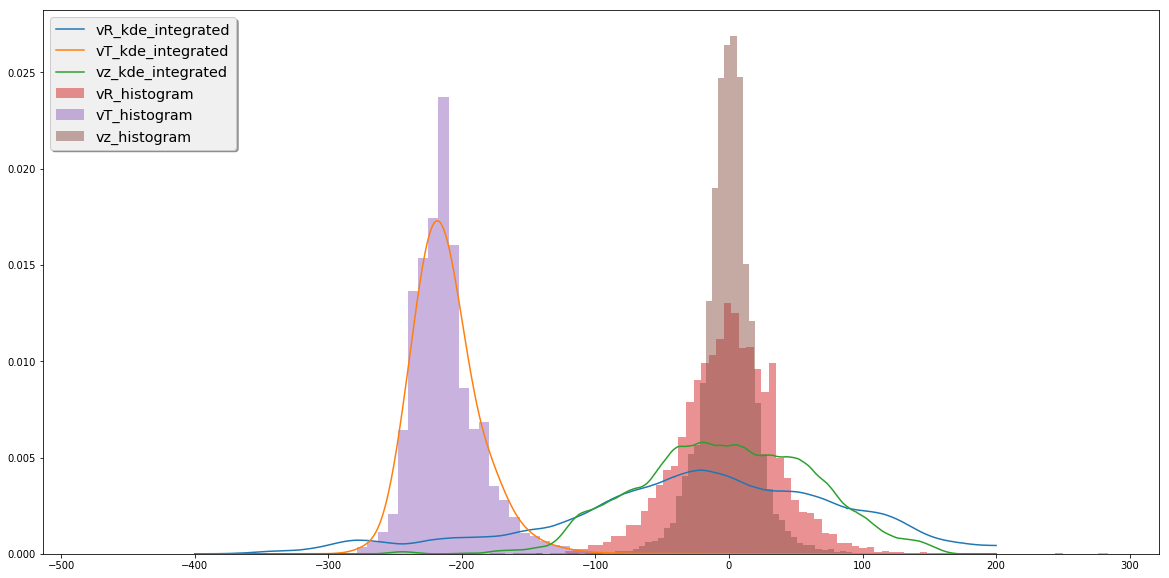

In [20]:
# overplotting qdf and kde integrated
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR_kde_integrated') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT_kde_integrated')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz_kde_integrated')
ax.hist(vR, bins=100, normed=True, label='vR_histogram', alpha=0.5)
ax.hist(vT, bins=100, normed=True, label='vT_histogram', alpha=0.5)
ax.hist(vz, bins=100, normed=True, label='vz_histogram', alpha=0.5)
#ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR_qdf_integrated')
#ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT_qdf_integrated')
#ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz_qdf_integrated')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
plt.savefig('gaia_zscore_cyl_integrated_histogram_1000pts')
plt.show()